<a href="https://colab.research.google.com/github/danielaterra/U-Net-Cervical-cells-ISBI2014-/blob/main/DanielaCostaTerra_Seg_ISBI2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Universidade Federal de Ouro Preto
Departamento de Ciência da Computação
Programa de Pós-graduação em Ciência da Computação*
 
**Autor: Daniela Costa Terra**

Título: "Segmentação de Células Cervicais da Base ISBI2014 com a Arquitetura U-Net"*
*Julho/2022*

### Importação de pacotes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import os
import pathlib
import time

from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml h5py  # Pra salvar modelos em formato HDF5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1. Pré-processamento das imagens 
*Dataset: ISBI-2014 (https://cs.adelaide.edu.au/~carneiro/isbi14_challenge/dataset)


#### **Aumento de dados**

O aumento de dados foi feito separadamente no script **[AumentoDadosISBI2014.ipynb](https://drive.google.com/file/d/11AzvoZ0TIl2J498WzVVIvJMhoW2SvULa/view?usp=sharing)** 
- Descrição: a partir do conjunto de 45 imagens de treinamento da base ISBI2014 disponível em https://cs.adelaide.edu.au/~carneiro/isbi14_challenge/. Para cada imagens de treino foram geradas 20 imagens transformadas com rotação,flip horizontal/vertical e corte aleatório (a partir das dimensões originais 512x512. As imagens foram todas redimensionadas em 128 x 128 pixels, contendo 1 canal (grayscale), acessível em CURRENT_PATH, em:

*   '/trainX': conjunto de treinamento (945 imagens). 
*   '/trainY': conjunto de máscaras de treinamento (945).  
*   '/valX': conjunto de validação (90 imagens originais da base).  
*   '/valY': conjunto 90 de máscaras de validação da base original 

Obs.: 
1. Os arquivos "trainISBI2014.csv" e "valISBI2014.csv" são lidos pelo objeto ImageDataGenerator para associar cada imagem sua máscara ('features','labels') nas bases de treino e validação, respectivamente.
 


####Pipeline para imagens/máscaras (treino e validação)

In [ ]:
CURRENT_PATH = '/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3'

In [ ]:
# Pipelines para leitura das imagens:
train_annot = pd.read_csv(CURRENT_PATH+'/dataset/trainISBI2014.csv',header=0)
val_annot = pd.read_csv(CURRENT_PATH+'/dataset/valISBI2014.csv',header=0)

#Testar - train (945) e val_annot (90)
train_annot, val_annot

(                  features                     label
 0        ./trainX/SYN1.png      ./trainY/SYN1_GT.png
 1       ./trainX/SYN10.png     ./trainY/SYN10_GT.png
 2     ./trainX/SYN10_1.png   ./trainY/SYN10_1_GT.png
 3    ./trainX/SYN10_10.png  ./trainY/SYN10_10_GT.png
 4    ./trainX/SYN10_11.png  ./trainY/SYN10_11_GT.png
 ..                     ...                       ...
 940    ./trainX/SYN9_5.png    ./trainY/SYN9_5_GT.png
 941    ./trainX/SYN9_6.png    ./trainY/SYN9_6_GT.png
 942    ./trainX/SYN9_7.png    ./trainY/SYN9_7_GT.png
 943    ./trainX/SYN9_8.png    ./trainY/SYN9_8_GT.png
 944    ./trainX/SYN9_9.png    ./trainY/SYN9_9_GT.png
 
 [945 rows x 2 columns],              features                 label
 0   ./valX/SYN100.png  ./valY/SYN100_GT.png
 1   ./valX/SYN101.png  ./valY/SYN101_GT.png
 2   ./valX/SYN102.png  ./valY/SYN102_GT.png
 3   ./valX/SYN103.png  ./valY/SYN103_GT.png
 4   ./valX/SYN104.png  ./valY/SYN104_GT.png
 ..                ...                   ...
 85   ./val

In [ ]:
OUTPUT_CHANNELS = 1
BATCH_SIZE = 16
 
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainX_generator = train_datagen.flow_from_dataframe(dataframe=train_annot,
    directory=CURRENT_PATH+'/dataset/', 
    class_mode=None, x_col='features', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

trainY_generator = train_datagen.flow_from_dataframe(dataframe=train_annot,
    directory=CURRENT_PATH+'/dataset/', 
    class_mode= None, x_col='label', y_col= None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE,shuffle=False)

train_generator = zip(trainX_generator, trainY_generator)

Found 945 validated image filenames.
Found 945 validated image filenames.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

valX_generator = val_datagen.flow_from_dataframe(dataframe=val_annot,
    directory=CURRENT_PATH+'/dataset/', 
    class_mode=None, x_col='features', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

valY_generator = val_datagen.flow_from_dataframe(dataframe=val_annot,
    directory=CURRENT_PATH+'/dataset/', 
    class_mode=None, x_col='label', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

val_generator = zip(valX_generator, valY_generator)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [ ]:
#Exibe imagem, máscasra e predição da segmentação (se 'pred')
def show(image, label, pred=None):
  if  pred is not None:
      _, axis = plt.subplots(1, 3, figsize=(9,5))
      axis[0].imshow(tf.squeeze(image), cmap='gray')
      axis[0].set_title("Imagem") 
      axis[1].imshow(tf.squeeze(label), cmap='gray')
      axis[1].set_title("Máscara") 
      axis[2].imshow(tf.squeeze(label), cmap='gray')
      axis[2].set_title("Predicao") 
      for ax in axis:
           ax.set_axis_off()
      plt.show()    
  else:
      _, axis = plt.subplots(1, 2, figsize=(9,5))
      axis[0].imshow(tf.squeeze(image), cmap='gray')
      axis[0].set_title("Imagem") 
      axis[1].imshow(tf.squeeze(label),  cmap='gray')
      axis[1].set_title("Máscara") 
      for ax in axis:
           ax.set_axis_off()
      plt.show()

*Teste carga datasets:*

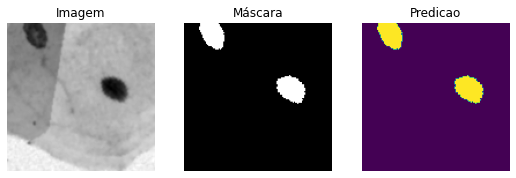

In [ ]:
# Exemplo - conjunto de treino:
images= trainX_generator.next()
labels = trainY_generator.next()
show(images[0], labels[0])

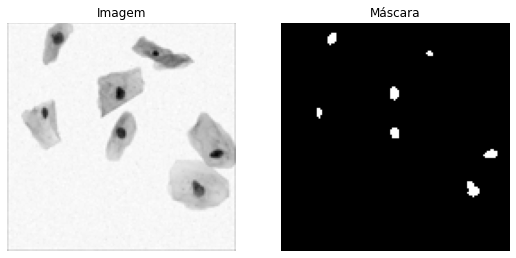

In [ ]:
# Exemplo conjunto de validação:
sample_images = valX_generator.next()
sample_labels = valY_generator.next()
show(sample_images[0], sample_labels[0])

##2. Definção do modelo baseado na U-Net 
Obs.: arquitetura de rede com número de blocos e camadas no mesmo formato original proposto por Ronneberger (2015), embora com conexões de salto sem cortes (Crop). Baseado na rede proposta em  https://github.com/kimoktm/U-Net, com modificações para uso do keras tensorflow e camada de saída de 1 canal com ativação sigmoide.

In [ ]:
DROPOUT_PROB = 0.3

In [ ]:
## Gera convoluções para Downsampling/Upsampling:
def conv_btn(filters, kernel, strides, apply_batchnorm=True, training=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, kernel, strides=strides, padding='same',
                             kernel_initializer=initializer))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())
  return result


### Unet como classe
(não usado)

In [ ]:
## U-NET Model, conforme modelo U-NET de Ronneberger(2015):
class Unet(tf.keras.Model):
  def __init__(self):
    super(Unet, self).__init__()
    self.inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    self.initializer = tf.random_normal_initializer(0., 0.02)
    # Encoder Section
    # Block 1   (128)
    conv1_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    conv1_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    self.block_1 = [conv1_1, conv1_2, pool1]

    # Block 2  (64)
    conv2_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    conv2_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    self.block_2 = [conv2_1, conv2_2, pool2]

    # Block 3  (32)
    conv3_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    conv3_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop3 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_3 = [conv3_1, conv3_2, pool3, drop3]

    # Block 4  (16)
    conv4_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    conv4_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop4 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_4 = [conv4_1, conv4_2, pool4, drop4]

    # Block 5  (8)
    conv5_1 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    conv5_2 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    drop5 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_5 = [conv5_1, conv5_2, drop5]

    # Decoder Section
    # Block 6   (8)
    upsample6 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (16)
    #concat6 = tf.keras.layers.concatenate([upsample6, conv4_2])  
    conv6_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    conv6_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    drop6 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_6 = [upsample6, None, conv6_1, conv6_2, drop6]

    # Block 7  (16)
    upsample7 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (32)
    #concat7 = tf.keras.layers.concatenate([upsample7, conv3_2])  
    conv7_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    conv7_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    drop7 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_7 = [upsample7, None, conv7_1, conv7_2, drop7]

    # Block 8  (32)
    upsample8 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (64)
    #concat8 = tf.keras.layers.concatenate([upsample8, conv2_2])  
    conv8_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    conv8_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    drop8 = tf.keras.layers.Dropout(DROPOUT_PROB)
    self.block_8 = [upsample8, None, conv8_1, conv8_2, drop8]

    # Block 9 (64)
    upsample9 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (128)
    #concat9 = tf.keras.layers.concatenate([upsample9, conv1_2])  
    conv9_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    conv9_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    drop9 = tf.keras.layers.Dropout(DROPOUT_PROB)
    
    # Block 9 output (conv 1x1)  (128)
    score9_1 = tf.keras.layers.Conv1D(2, 1, strides=1, activation='softmax')
    #score9_2 = tf.keras.layers.Reshape((-1, 128, 128, 1))
    self.block_9 = [upsample9, None, conv9_1, conv9_2, drop9, score9_1] 

  def call(self, x):
    # Downsampler:
    for i in range(3): # bloco 1 (128)
       x = self.block_1[i](x)
       if (i == 1):  ## salva para skip conection
          conv1_2 = x

    for i in range(3): # bloco 2  (64)
       x = self.block_2[i](x)
       if (i == 1):   ## salva para skip conection
          conv2_2 = x
    for i in range(4): # bloco 3  (32)
       x = self.block_3[i](x)
       if (i == 1):   ## salva para skip conection
          conv3_2 = x

    for i in range(4): # bloco 4  (16)
        x = self.block_4[i](x)
        if (i == 1):   ## salva para skip conection
            conv4_2 = x
            print("bloco 4: ", conv4_2.shape)
    
    for i in range(3): # bloco 5  (8)
        x = self.block_5[i](x)
    
    # Upsampler:

    for i in range(5): # bloco 6  (8)
        if (i == 1):   ## obtem skip conection do enconder conv4_2
           x = tf.keras.layers.concatenate([x, conv4_2])
           print("Bloco 6 if:", i, x.shape)  
        else: 
           print("Bloco 6 antes else:", i, x.shape)  
           x = self.block_6[i](x)    
           print("Bloco 6 else:", i, x.shape)  

    for i in range(5): # bloco 7
        if (i == 1):   ## obtem skip conection do enconder conv3_2
           x = tf.keras.layers.concatenate([x, conv3_2]) 
        else:   
           x = self.block_7[i](x)          

    for i in range(5):   # bloco 8
        if (i == 1):   ## obtem skip conection do enconder conv2_2
           x = tf.keras.layers.concatenate([x, conv2_2]) 
        else:   
           x = self.block_8[i](x)  

    for i in range(6): # bloco 9
        if (i == 1):   ## obtem skip conection do enconder conv1_2
           x = tf.keras.layers.concatenate([x, conv1_2]) 
        else:   
           x = self.block_9[i](x)        

    return x 


### **U-Net Model (como função)**

In [ ]:
def unet_model(output_channels):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs

  # Downsampling (blocos de 1 à 5)
  # Block 1   (128) -> 64
    conv1_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    conv1_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    block_1 = [conv1_1, conv1_2, pool1]

    # Block 2  (64) -> 32
    conv2_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    conv2_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    block_2 = [conv2_1, conv2_2, pool2]

    # Block 3  (32) -> 16
    conv3_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    conv3_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop3 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_3 = [conv3_1, conv3_2, pool3, drop3]

    # Block 4  (16) -> 8
    conv4_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    conv4_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop4 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_4 = [conv4_1, conv4_2, pool4, drop4]

    # Block 5  (8)  
    conv5_1 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    conv5_2 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    drop5 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_5 = [conv5_1, conv5_2, drop5]

    # Upsampling (blocos de 6 à 9)
    # Block 6   (8) -> 16
    upsample6 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (16)
    #Inclusão posterior de: concat6 = tf.keras.layers.concatenate([upsample6, conv4_2])  
    conv6_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    conv6_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    drop6 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_6 = [upsample6, None, conv6_1, conv6_2, drop6]

    # Block 7  (16) 
    upsample7 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (32)
    #Inclusão posterior de: concat7 = tf.keras.layers.concatenate([upsample7, conv3_2])  
    conv7_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    conv7_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    drop7 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_7 = [upsample7, None, conv7_1, conv7_2, drop7]

    # Block 8  (32)
    upsample8 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (64)
    #Inclusão posterior de: concat8 = tf.keras.layers.concatenate([upsample8, conv2_2])  
    conv8_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    conv8_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    drop8 = tf.keras.layers.Dropout(DROPOUT_PROB)
    block_8 = [upsample8, None, conv8_1, conv8_2, drop8]

    # Block 9 (64)
    upsample9 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (128)
    #Inclusão posterior de: concat9 = tf.keras.layers.concatenate([upsample9, conv1_2])  
    conv9_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    conv9_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    drop9 = tf.keras.layers.Dropout(DROPOUT_PROB)
    # Output (conv 1x1)  (128)
    score9_1 = tf.keras.layers.Conv1D(1, 1, strides=1, activation='sigmoid')
    block_9 = [upsample9, None, conv9_1, conv9_2, drop9, score9_1] 

    # Construção da pilha de blocos:
    # Downsampler (decoder) 
    for i in range(3): # bloco 1 (128)
       x = block_1[i](x)
       if (i == 1):    ## salva filtros para skip conection
          conv1_2 = x
    for i in range(3): # bloco 2  (64)
       x = block_2[i](x)
       if (i == 1):   ## salva filtros para skip conection
          conv2_2 = x
    for i in range(4): # bloco 3  (32)
       x = block_3[i](x)
       if (i == 1):   ## salva filtros para skip conection
          conv3_2 = x
    for i in range(4): # bloco 4  (16)
        x = block_4[i](x)
        if (i == 1):   ## salva filtros para skip conection
            conv4_2 = x
    for i in range(3): # bloco 5  (8)
        x = block_5[i](x)
    
    # Upsampler:
    for i in range(5): # bloco 6  (8)
        if (i == 1):   ## obtem skip conection do enconder conv4_2
           x = tf.keras.layers.concatenate([x, conv4_2])
        else: 
           x = block_6[i](x)    

    for i in range(5): # bloco 7
        if (i == 1):   ## skip conection (conv3_2)
           x = tf.keras.layers.concatenate([x, conv3_2]) 
        else:   
           x = block_7[i](x)          

    for i in range(5):   # bloco 8
        if (i == 1):   ## skip conection (conv2_2)
           x = tf.keras.layers.concatenate([x, conv2_2]) 
        else:   
           x = block_8[i](x)  

    for i in range(6): # bloco 9
        if (i == 1):   ## skip conection (conv1_2)
           x = tf.keras.layers.concatenate([x, conv1_2]) 
        else:   
           x = block_9[i](x)        
 
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Teste modelo Unet
model = unet_model(1)
x = tf.ones([1, 128, 128, 1], tf.float32)
model(x).shape 

TensorShape([1, 128, 128, 1])

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.summary()

### Funções treinamento e métricas:


In [ ]:
# Cria máscara a partir da predição (não usada)
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
## Binariza (ex.: uso para máscara predita)
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [ ]:
#Exibe imagem/máscara/predição:
def show_predictions(dataset=None, model = None, num=1):
  if dataset is not None:
     count = 0
     for features, labels in dataset:
        print(features.shape, labels.shape)
        for i in range(features.shape[0]):
           pred = tf.expand_dims(features[i], axis=0)
           show(features[i], labels[i], model.predict(pred))
           count= count + 1
           if (count >= num):
               break
        if (count >= num):
            break
  else:
     if num > 1:  #exibe lote pré-carregado     
        for i  in range(sample_images.shape[0]):
            show(sample_images[i], sample_labels[i],
                model.predict(tf.expand_dims(sample_images[i], axis=0)))
     else:   # exibe uma predição (usado no callback de treino)
        show(sample_images[0], sample_labels[0],
             model.predict(tf.expand_dims(sample_images[0], axis=0)))

In [ ]:
## Exibe predições durante o treino:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nPredição após a época {}\n'.format(epoch+1))

In [ ]:
# Exibe métricas de treino e validação ()
def plot_segm_history(history, epochs_ini, 
                      metrics=["dice_coef", "val_dice_coef"], losses=["loss", "val_loss"]):
    """
    Args:
        history: dicionário retornado de 'fit'
        metrics:  lista de métricas realizadas durante treino/validação
        losses: estatísticas de perda durante treino/validação 
    """

# Exibe métricas de treino e validação ()
def plot_segm_history(history, epochs_ini, 
                      metrics=["accuracy", "val_accuracy"], losses=["loss", "val_loss"]):
    """
    Args:
        history: dicionário retornado de 'fit'
        metrics:  lista de métricas realizadas durante treino/validação
        losses: estatísticas de perda durante treino/validação 
    """
    epochs =  history.params['epochs']

    _, axis = plt.subplots(1, len(metrics), figsize=(12,5))
    for i, metric in enumerate(metrics):
        axis[i].plot(history.history[metric], label=metric)
        axis[i].set_title(metric + ' over epochs') 
        axis[i].set_xlim([epochs_ini, epochs])
        axis[i].set_ylim([-1, tf.reduce_max(history.history[metric])*1.1+10])
        axis[i].legend()
 
    data = [] 
    # Gráfico history for loss:
    for loss in losses:
          data.append(history.history[loss])         
    plt.figure()
    plt.plot(list(range(epochs)), data[0], 'r', label='Training loss')
    plt.plot(list(range(epochs)), data[1], 'bo', label='Validation loss')
    plt.title("Loss over epochs")
    plt.ylabel("Loss Value")
    plt.xlabel("Epoch")
    plt.xlim([epochs_ini, epochs])
    plt.ylim([0, 1])
    plt.legend()
    plt.show()  

In [ ]:
## Coeficiente de similaridade de DICE: também referido como Zijdenbos similarity index(ZSI) ou F1 Score
def dice_coef(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    #print(y_pred, int(intersection))
    return (2. * intersection + smooth) /(
                tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

## DICE com limiar 
def dice_coef_thresholded(y_true, y_pred, threshold=0.7, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    #print(y_pred, int(intersection))
    return (2. * intersection + smooth) /(
                tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

In [ ]:
# Precisão: TPp/(TPp + FPp)
def precision_thresholded(y_true, y_pred, threshold=0.6):
    y_pred_f = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_f, [-1])    
    inter = y_true_f * y_pred_f
    tp = tf.math.reduce_sum(y_true_f * y_pred_f)
    fp = tf.math.abs(tf.math.reduce_sum(y_pred_f - inter))
    if (tf.math.reduce_sum(y_pred_f) == 0):  #divisão 0/0
       return tf.constant(0.0)
    else:
       return (tp /(tp + fp))

# Revocação: TPp/(TPp + FNp)
def recall_thresholded(y_true, y_pred, threshold=0.6):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    inter = y_true_f * y_pred_f
    tp = tf.math.reduce_sum(y_true_f * y_pred_f)
    fn = tf.math.abs(tf.math.reduce_sum(y_true_f - inter)) 
    return (tp /(tp + fn))
    

In [ ]:
#Teste métricas
t = tf.constant([[1, 0], [1, 1], [0, 0], [0, 0]], dtype=tf.float32)
p = tf.constant([[0.5, 0], [0.4, 0.4], [0, 0], [0, 0]], dtype=tf.float32) 
print(precision_thresholded(t, p))
print(recall_thresholded(t, p))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


##3. Treinamento do modelo: 

In [ ]:
EPOCHS = 36
TRAIN_LENGTH = 945
VAL_LENGTH = 90
BATCH_SIZE = 16
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TRAIN_LENGTH, STEPS_PER_EPOCH
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE
(TRAIN_LENGTH, STEPS_PER_EPOCH, VALIDATION_STEPS)

(945, 59, 5)

In [ ]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints')
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


Arquivo para checkpoint:

In [ ]:
checkpoint_filename = "segm_unet_model_v0.h5"
checkpoint_path = os.path.join(CURRENT_PATH+"/checkpoints/training_0", checkpoint_filename)

checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
from keras.callbacks import ModelCheckpoint

# Create a callback that saves the model's weights
callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [ ]:
# Loss function:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits= False)
# Otimizador:
optimizer_object = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
model.compile(optimizer= optimizer_object, loss= loss_object, metrics=['accuracy', dice_coef, dice_coef_thresholded])

###Treinamento: (10 epócas)

In [ ]:
# 10 épocas iniciais:
history_0 = model.fit(train_generator,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=10,
          initial_epoch=0,
          validation_steps= VALIDATION_STEPS,
          validation_data= val_generator,
          callbacks=[callback_checkpoint])         
          #callbacks=[DisplayCallback(), callback_checkpoint])         

Epoch 1/10
Tensor("SelectV2:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_5:0", shape=(), dtype=int32)
Tensor("SelectV2_1:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_7:0", shape=(), dtype=int32)
Tensor("SelectV2:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_5:0", shape=(), dtype=int32)
Tensor("SelectV2_1:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_7:0", shape=(), dtype=int32)
59/59 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9824 - dice_coef: 0.6513 - dice_coef_thresholded: 0.6448Tensor("SelectV2:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_5:0", shape=(), dtype=int32)
Tensor("SelectV2_1:0", shape=(None, 128, 128, 1), dtype=float32) Tensor("Cast_7:0", shape=(), dtype=int32)

Epoch 1: val_loss improved from inf to 0.22894, saving model to /content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints/training_0/segm_unet_model_v0.h5
59/59 [=======================

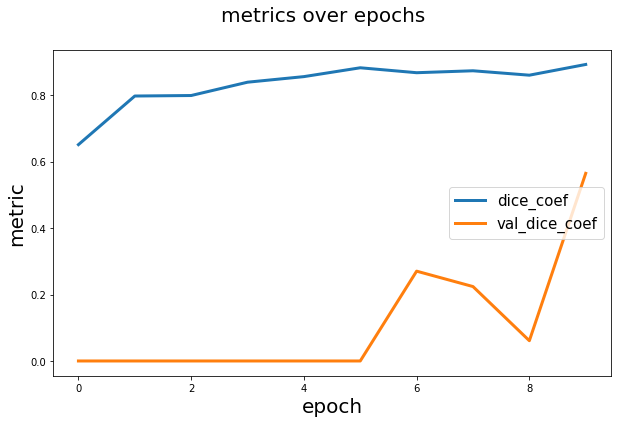

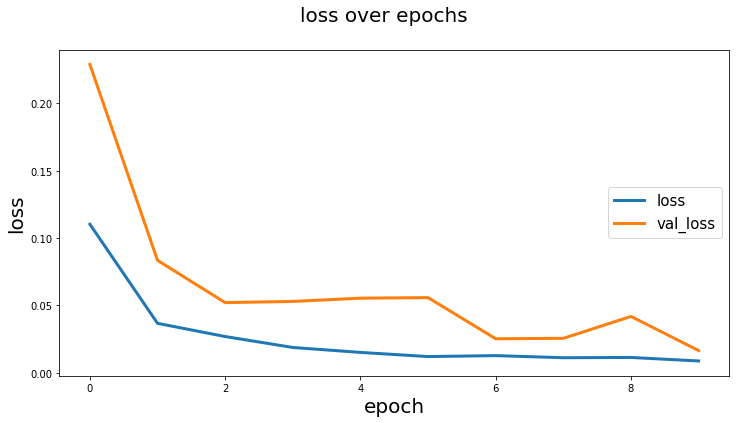

In [ ]:
## Gráficos Treinamento (épocas 0 - 10):
plot_segm_history(history_0, 0)  //epochs_ini = 0

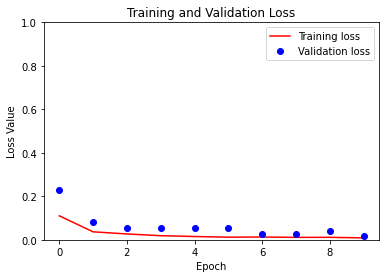

In [ ]:
#EXCLUIR após testar plot_segm_history
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']
epochs = range(10)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

####Salva modelo (0 - 10 epócas)

In [ ]:
model_filename = "segm_unet_model_10Epochs.h5"
model_file = os.path.join(CURRENT_PATH+"/checkpoints/", model_filename)
model_dir_gdrive = os.path.dirname(model_file)

In [ ]:
model.save(model_file)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3//checkpoints/segm_unet_model_10Epochs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3//checkpoints/segm_unet_model_10Epochs/assets


In [ ]:
drive.flush_and_unmount()

In [ ]:
os.listdir(model_dir_gdrive)

['training_0',
 '.ipynb_checkpoints',
 'training_1',
 'segm_unet_model.h5',
 'segm_unet_model_10Epochs']

###Treinamento: épocas 10 à 36:

In [ ]:
model.load_weights(model_file)

In [ ]:
checkpoint_filename = "segm_unet_model_v0.h5"
checkpoint_path = os.path.join(CURRENT_PATH+"/checkpoints/training_1", checkpoint_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
os.listdir(checkpoint_dir)

[]

In [ ]:
# Épocas de 10 à 36:
history_1 = model.fit(train_generator,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs= EPOCHS,
          initial_epoch=10,
          validation_steps=VALIDATION_STEPS,
          validation_data= val_generator,
          callbacks=[callback_checkpoint])  
          #callbacks=[DisplayCallback(), callback_checkpoint])  

Epoch 11/36
59/59 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9933 - dice_coef: 0.6692 - dice_coef_thresholded: 0.6179
Epoch 11: val_loss did not improve from 0.01651
59/59 [==============================] - 16s 264ms/step - loss: 0.0251 - accuracy: 0.9933 - dice_coef: 0.6692 - dice_coef_thresholded: 0.6179 - val_loss: 0.0334 - val_accuracy: 0.9869 - val_dice_coef: 0.5748 - val_dice_coef_thresholded: 0.6986
Epoch 12/36
59/59 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9957 - dice_coef: 0.8318 - dice_coef_thresholded: 0.8117
Epoch 12: val_loss did not improve from 0.01651
59/59 [==============================] - 16s 273ms/step - loss: 0.0138 - accuracy: 0.9957 - dice_coef: 0.8318 - dice_coef_thresholded: 0.8117 - val_loss: 0.0354 - val_accuracy: 0.9852 - val_dice_coef: 0.5411 - val_dice_coef_thresholded: 0.6159
Epoch 13/36
59/59 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9964 - dice_coef: 0.8619 - dice_

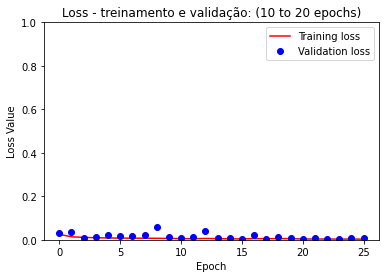

In [ ]:
#EXCLUIR APÓS TESTE  de plot_segm_history:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(EPOCHS-10)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Loss - treinamento e validação: (10 to 36 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

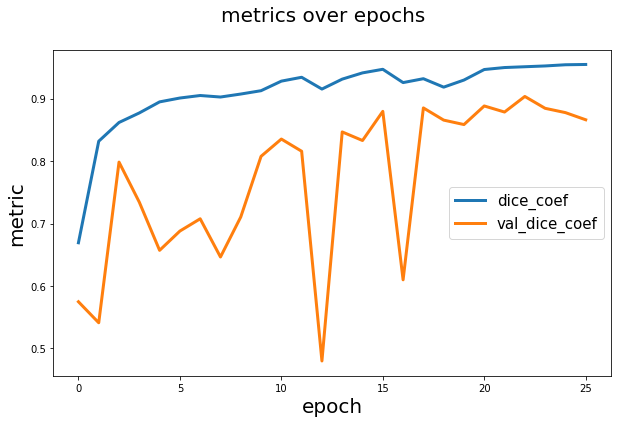

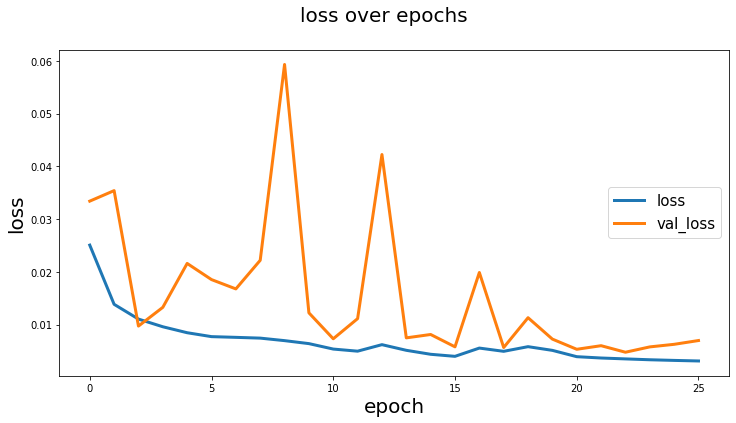

In [ ]:
## Gráficos Treinamento (épocas 10 - 36):
plot_segm_history(history_1, 10)  # epochs_ini = 10 

####Salva modelo (10 - 36 epócas)

In [ ]:
model_filename = "segm_unet_model_36Epochs.h5"
model_file = os.path.join(CURRENT_PATH+"/checkpoints/", model_filename)
model_dir_gdrive = os.path.dirname(model_file)

In [ ]:
model.save(model_file)

In [ ]:
os.listdir(model_dir_gdrive)

##4. Avaliação do modelo treinado:

---



In [ ]:
model_filename = "segm_unet_model_36Epochs.h5"
model_file = os.path.join(CURRENT_PATH+"/checkpoints/", model_filename)
model_dir_gdrive = os.path.dirname(model_file)

In [ ]:
os.listdir(model_dir_gdrive)

['training_0',
 '.ipynb_checkpoints',
 'training_1',
 'segm_unet_model_10Epochs',
 'segm_unet_model_36Epochs.h5']

In [ ]:
model.load_weights(model_file)

####Exibe predições:

(16, 128, 128, 1) (16, 128, 128, 1)


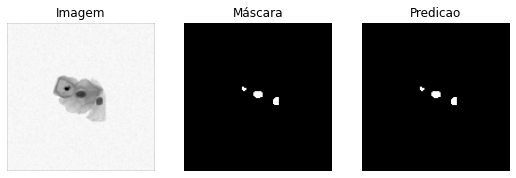

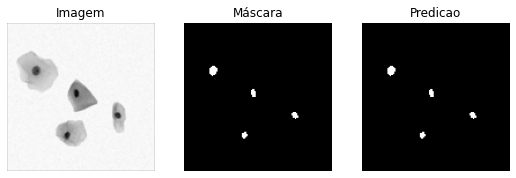

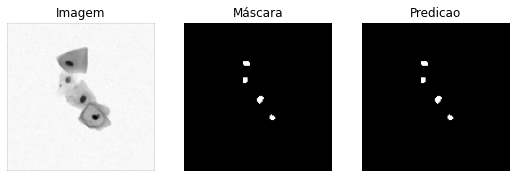

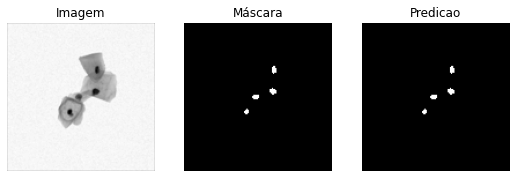

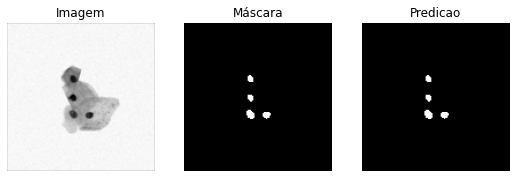

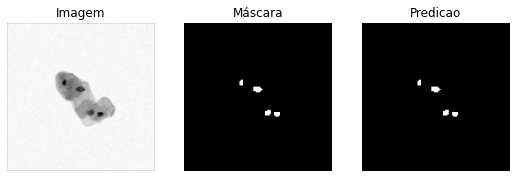

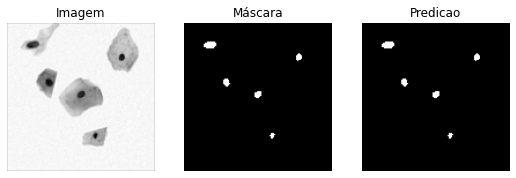

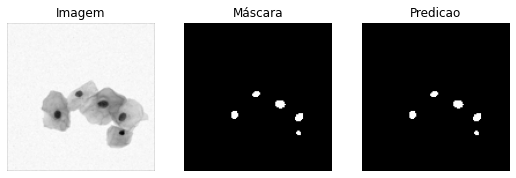

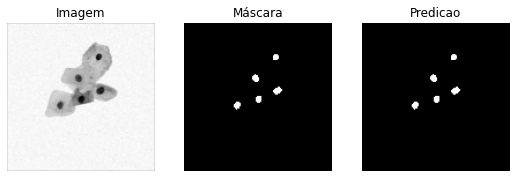

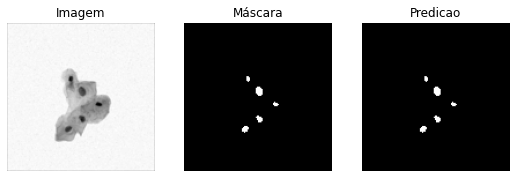

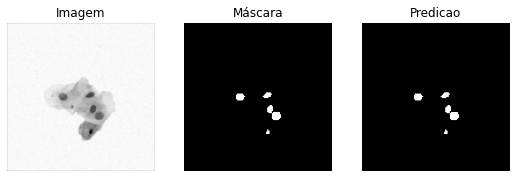

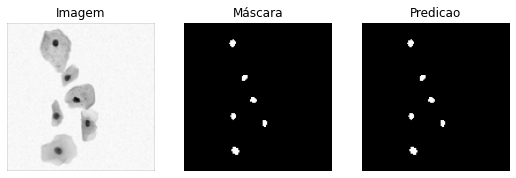

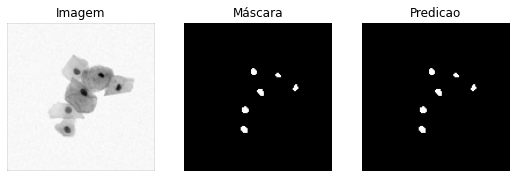

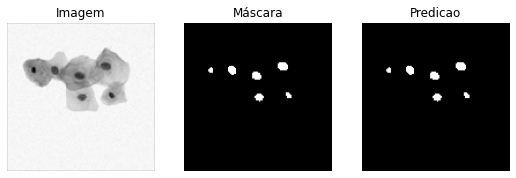

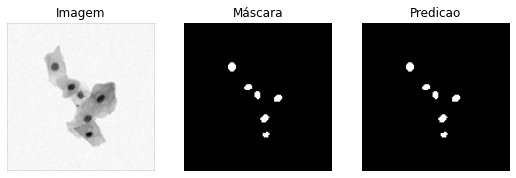

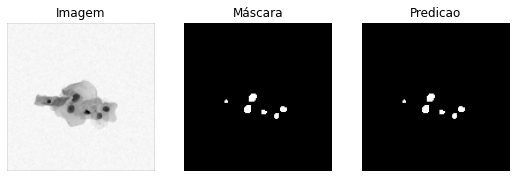

(16, 128, 128, 1) (16, 128, 128, 1)


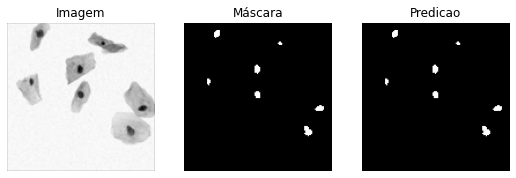

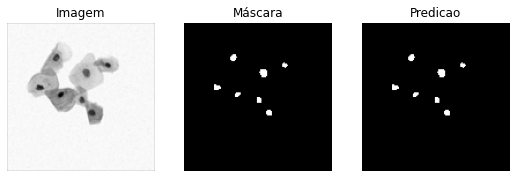

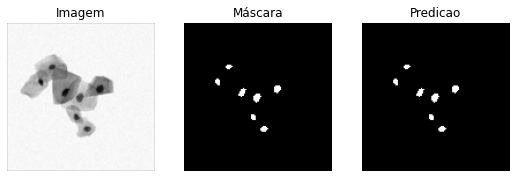

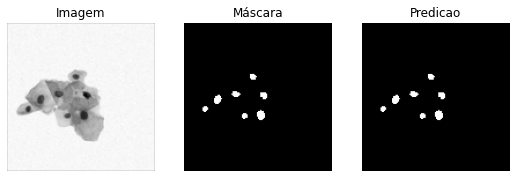

In [ ]:
# Teste das predições de segmentação do modelo (base de validação)
#show_predictions(model = model, num=BATCH_SIZE) 
show_predictions(val_generator, model = model, num= 20)

####Exibe estatísticas do conjunto de teste (Dice, precisão e revocação):
- Dice com threshold de 0.7
- Precisão e revocação (threshold de 0.6)

In [ ]:
# Exibe métricas das predições do modelo (base de validação): 
# Alterar para predição em batch 
def show_segmentation_metrics(model=model, tdice=0.7, tprecision=0.6, trecall=0.6):
    dice_07 = []
    precision_06 = []
    recall_06 = []
    count = 0
    for features, labels in val_generator:
      for i in range(features.shape[0]):
          pred = model.predict(tf.expand_dims(features[i], axis=0))
          dice_07.append(dice_coef_thresholded(labels[i], pred, threshold=tdice))
          precision_06.append(precision_thresholded(labels[i], pred, threshold=tprecision))
          recall_06.append(recall_thresholded(labels[i], pred, threshold=trecall))
          count+=1
          if (count >=90):
             break
      #print(count, features.shape[0])    
      if (count >=90):   ## para evitar reinicio do val_generator
             break
    # Exibe métricas:  
    dice = tf.math.reduce_mean(dice_07)
    precision = tf.math.reduce_mean(precision_06)
    recall = tf.math.reduce_mean(recall_06)
    print('Resultados da predição: \n')
    print('Coeficiente de Dice (threshold=0.7): {:2.3%}'.format(dice))
    print('Precisão (threshold=0.6): {:2.3%}'.format(precision))
    print('Revocação (threshold=0.6): {:2.3%}'.format(recall))

In [ ]:
show_segmentation_metrics(model, tdice=0.7, tprecision=0.6, trecall=0.6)

Resultados da predição: 

Coeficiente de Dice (threshold=0.7): 89.266%
Precisão (threshold=0.6): 83.162%
Revocação (threshold=0.6): 95.309%


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
# Memória space:
!cat /proc/meminfo

In [ ]:
# Disk space:
!df -h

In [ ]:
from psutil import *

In [ ]:
cpu_count()

2

In [ ]:
cpu_stats()

scpustats(ctx_switches=926394, interrupts=673692, soft_interrupts=597732, syscalls=0)

In [ ]:
!cat /proc/cpuinfo

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cd47f662-b44f-89e3-e0ef-3873f85c06e8)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2


In [ ]:
!lscpu | grep "L3 cache" 

L3 cache:            39424K


In [ ]:
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at shown frequency
!lscpu | grep "MHz"

CPU MHz:             2000.192


In [ ]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

13G
